In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy



# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [3]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/2024-04-09-DATASET-ML.xlsx')
# df = pd.read_excel('../lc-project-data/2024-04-10-DATASET.xlsx')
# df = pd.read_excel('../lc-project-data/2024-04-11-DATASET.xlsx')
df = pd.read_excel(
    "../Data/Original Data/2024_04_26/FINAL CORRECTED DATA 2024-04-26.xlsx"
)

In [4]:
df.shape

(5664, 692)

In [5]:
# preserve a copy for experimentation; we can allways reset to this and faster than reloading the excel file
preserved_df = deepcopy(df)
preserved_df.shape

(5664, 692)

In [6]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

## QA

In [7]:
df = preserved_df

In [8]:
# summarize the info about the dataframe
# note the number of columns of each type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 692 entries, record_id to biospecimen_complete
dtypes: datetime64[ns](7), float64(655), int64(10), object(20)
memory usage: 29.9+ MB


In [9]:
# A list of columns to drop
to_drop = []

In [10]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()
print(nan_cols)
to_drop.extend(nan_cols)

['other_hhx4', 'other_hhx5', 'other_hhx6', 'other_hhx7', 'other_hhx8', 'other_hhx9', 'other_hhx10', 'medication8', 'medication9', 'medication11', 'medication12', 'medication13', 'medication14', 'medication15', 'urine', 'pao2', 'sao2', 'ph', 'paco2', 'hco3', 'aexcess', 'alactate', 'clinical_note_upload']


In [11]:
# values in gender column are very sparse
print(df["gender"].value_counts())
print(f"Nulls = {df['gender'].isna().sum()}")

# drop gender column - mostly NaN
to_drop.append("gender")


gender
FEMALE                149
MALE                   64
Male                    4
TRANSGENDER FEMALE      1
Name: count, dtype: int64
Nulls = 5446


In [12]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

# info on the adjunctive columns
print(preserved_df[adj_cols].info())
print(preserved_df[adj_cols].describe())
print(preserved_df[adj_cols[1]].value_counts())

# all but the first adjunctive column are zeros/nans
# add them to the list to drop
to_drop.extend(adj_cols[1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adjunctive___1   3367 non-null   float64
 1   adjunctive___2   3363 non-null   float64
 2   adjunctive___3   3254 non-null   float64
 3   adjunctive___4   3254 non-null   float64
 4   adjunctive___5   3254 non-null   float64
 5   adjunctive___6   3254 non-null   float64
 6   adjunctive___7   3254 non-null   float64
 7   adjunctive___8   3254 non-null   float64
 8   adjunctive___9   3254 non-null   float64
 9   adjunctive___10  3254 non-null   float64
dtypes: float64(10)
memory usage: 442.6 KB
None
       adjunctive___1  adjunctive___2  adjunctive___3  adjunctive___4  \
count     3367.000000     3363.000000          3254.0          3254.0   
mean         0.032076        0.000297             0.0             0.0   
std          0.176228        0.017244             0.0             0.0   
m

In [13]:
print(f"Dropping {len(to_drop)} columns")

to_drop

Dropping 33 columns


['other_hhx4',
 'other_hhx5',
 'other_hhx6',
 'other_hhx7',
 'other_hhx8',
 'other_hhx9',
 'other_hhx10',
 'medication8',
 'medication9',
 'medication11',
 'medication12',
 'medication13',
 'medication14',
 'medication15',
 'urine',
 'pao2',
 'sao2',
 'ph',
 'paco2',
 'hco3',
 'aexcess',
 'alactate',
 'clinical_note_upload',
 'gender',
 'adjunctive___2',
 'adjunctive___3',
 'adjunctive___4',
 'adjunctive___5',
 'adjunctive___6',
 'adjunctive___7',
 'adjunctive___8',
 'adjunctive___9',
 'adjunctive___10']

In [14]:
try:
    df = preserved_df.drop(columns = to_drop)
except KeyError:
    # already did it and reran the cell
    pass
df.shape

(5664, 659)

In [15]:
# get all column names
df_columns = df.columns

## TODO

In [16]:
# TODO: one-hot encode mode of diag


df["mode_of_diag"].value_counts(dropna=False)

mode_of_diag
1.0    3481
NaN    1108
2.0     863
0.0     184
5.0      20
3.0       7
4.0       1
Name: count, dtype: int64

# FEATURE SETS

## LC+, LC-, HC

- make a new column to encode status of reach record

In [17]:
# LC_positive types
pos_vals = [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals  = [3,11, 14,15]

LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC     = df.query('participant_type in @hc_vals')


df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

df['LC_STATUS'].value_counts()

LC_STATUS
LC_NEG    3367
LC_POS    2215
HC          82
Name: count, dtype: int64

## DEMOGRAPHICS
- apr 27 - LUS increase in missing data for HCP and MICRO w apr 26 data

In [18]:
# record id
# we should leave this out - it is not useful as a feature
# it is a unique identifier for the record, but has various formats: ints, strings, uuids, etc and 
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", 
                "age", 
                # "home_location", 
                # "living_with", 
                # "number_of_persons_in_house"
                ]

# suggest leaving this out
# country of birth - not sure how useful this is
# there are about 100 different countries in the dataset, 
# with a long tail
BIRTH_COUNTRY    = [
                # "country"
                ]

# employment etc
# data is sparse, multilingual, and not useful
EMPLOYMENT   = [
                # "employed", 
                # "occupation", 
                "hcp", 
                "micro"
                ]

# the site at which the data was collected
# consider renaming this feature below
SITES        = ["dag"]

# this list drops the record id
demographic_features = df[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES]
# demographic_features = df[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES]

demographic_features.shape

(5664, 5)

In [19]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     5614 non-null   float64
 1   age     5620 non-null   float64
 2   hcp     3290 non-null   float64
 3   micro   3163 non-null   float64
 4   dag     5664 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 221.4 KB


In [20]:
# how many nulls per site?
print("Missing DEMOGRAPHICS values by site:")
df.groupby('dag')[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing DEMOGRAPHICS values by site:


dag,LDN,MTL,SAN,RIO,LUS
sex,0,0,0,1,49
age,1,0,0,1,42
hcp,80,148,224,734,1188
micro,90,158,227,768,1258
dag,0,0,0,0,0


In [21]:
# drop hcp and micro columns - they are mostly NaN

# drop the columns
demographic_features.drop(columns = ["hcp", "micro"], inplace = True)
demographic_features.shape

/tmp/ipykernel_35795/1475034333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_features.drop(columns = ["hcp", "micro"], inplace = True)


(5664, 3)

### PARTICIPANT TYPES

- summary for each participant type
- not a feature set
- information only

In [22]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

LC_STATUS,HC,LC_NEG,LC_POS
participant_type,,,
1,0,7,0
2,0,0,75
3,38,0,0
4,0,0,241
5,0,328,0
6,0,0,1690
7,0,1886,0
8,0,0,83
10,0,1146,0


In [23]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'dag', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

dag,1,2,3,4,5
participant_type,,,,,
1,2,0,0,0,5
2,33,0,39,0,3
3,0,0,0,0,38
4,0,241,0,0,0
5,0,328,0,0,0
6,77,592,227,651,143
7,175,523,71,128,989
8,0,83,0,0,0
10,0,1146,0,0,0


### SITES

- summary of LC status by site
- not a feature set
- information only

In [24]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)

lc_site

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,32,177,110
MTL,0,1997,916
SAN,3,71,266
RIO,9,128,651
LUS,38,994,272


In [25]:
# how many records per site?
df['dag'].value_counts().rename(index = site_name_dict)

dag
MTL    2913
LUS    1304
RIO     788
SAN     340
LDN     319
Name: count, dtype: int64

In [26]:
# get the range of indices for each site
site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

/tmp/ipykernel_35795/1871863930.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore


dag
MTL       (0, 2912)
RIO    (2913, 3700)
LUS    (3701, 5624)
SAN    (4969, 5663)
LDN    (5270, 5590)
dtype: object

## SUBSTANCE USE

In [27]:
# substances
SUBSTANCES = [col for col in df.columns if "substances___" in col]

substance_features = df[SUBSTANCES]

# rename the columns with SUBST- prefix
substance_features.columns = [f"SUBST-{col.split('___')[1]}" for col in substance_features.columns]

# fill na with 0
# substance_features = substance_features.fillna(0)

In [28]:
substance_features.head(), substance_features.shape

(   SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5
 0      0.0      0.0      NaN      0.0      0.0
 1      0.0      0.0      NaN      0.0      0.0
 2      0.0      0.0      NaN      0.0      0.0
 3      1.0      0.0      NaN      0.0      0.0
 4      0.0      0.0      NaN      0.0      0.0,
 (5664, 5))

In [29]:
# how many nulls per site?
print("Missing SUBSTANCES values by site:")
df.groupby('dag')[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site:


dag,LDN,MTL,SAN,RIO,LUS
substances___1,81,0,0,0,0
substances___2,81,0,0,121,1258
substances___3,81,2913,0,121,0
substances___4,81,0,0,121,1258
substances___5,81,0,0,121,0


In [30]:
substance_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SUBST-1  5583 non-null   float64
 1   SUBST-2  4204 non-null   float64
 2   SUBST-3  2549 non-null   float64
 3   SUBST-4  4204 non-null   float64
 4   SUBST-5  5462 non-null   float64
dtypes: float64(5)
memory usage: 221.4 KB


### CONCLUSION: 
- do not use the SUBSTANCES columns, as there is significant missing data

## MEDICATIONS
 - one hot encode

In [31]:
# medications
# note that we already dropped the empty medication columns above
# h/t to Maitray for a nice one liner list comp
MEDTEMP = [col for col in df_columns if "medication" in col and 'medication_received' not in col]
MEDTEMP

['medication1',
 'medication2',
 'medication3',
 'medication4',
 'medication5',
 'medication6',
 'medication7',
 'medication10']

In [32]:
# read medications dict from json
import json

with open("./OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [33]:

med_df = pd.DataFrame()

print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDTEMP].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDTEMP):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDTEMP):>4d} columns")

# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index) # type: ignore

print(med_df.shape)


# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})


>>> constructing binary columns for each unique medication
>>> 	- will add      29 NEW columns
>>> 	- will remove    8 OLD columns
>>> 	- net change    21 columns
(5664, 29)


In [34]:
# originally, I was replacing the medication columns with the new ones
# however, we won't do that here, as we want to keep the original columns

# # drop the original meds columns
# try:
#     df = df.drop(columns = MEDTEMP)
# except KeyError:
#     pass
# # df = df.drop(columns = MEDICATIONS)

# # concatenate the med_df with the original df
# df = pd.concat([df, med_df], axis = 1)


# new name for medication columns
MEDICATIONS = med_df.columns.tolist()

medication_features = med_df

In [35]:
medication_features

,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,MED-Antiparasitics,MED-Antiparkinson-agents,MED-Antipsychotics,...,MED-Hormonal-agents-(adrenal),MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Immunological-agents,MED-Inflammatory-bowel-disease-agents,MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
medication_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   MED-Analgesics                         5664 non-null   int64
 1   MED-Anesthetics                        5664 non-null   int64
 2   MED-Antibacterials                     5664 non-null   int64
 3   MED-Anticonvulsants                    5664 non-null   int64
 4   MED-Antidepressants                    5664 non-null   int64
 5   MED-Antifungals                        5664 non-null   int64
 6   MED-Antimigraine-agents                5664 non-null   int64
 7   MED-Antiparasitics                     5664 non-null   int64
 8   MED-Antiparkinson-agents               5664 non-null   int64
 9   MED-Antipsychotics                     5664 non-null   int64
 10  MED-Antispasticity-agents              5664 non-null   int64
 11  MED-Antivirals                

## HEALTH HISTORY

### Patient History

In [37]:
# find all columns with hhx in the name
HEALTH_GLOBAL = ["global"]
HHX_temp      = [col for col in df_columns if "past_hhx" in col]


In [38]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("./OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [39]:
# make a subset of the df with the past_hhx columns
hhx_df = df[HHX_temp]

# rename the columns with HHX- prefix
hhx_df.columns = [f"HHX-{past_hhx_dict[int(col.split('___')[1])]}" for col in hhx_df.columns]

hhx_df


,HHX-Arterial Hypertension,HHX-Pulmonary hypertension,HHX-Cardiovascular disease,HHX-Diabetes,HHX-Cancer,HHX-Immunosuppression,HHX-Chronic lung disease,HHX-Chronic kidney disease,HHX-Dialysis,HHX-Chronic liver disease,...,HHX-Heart failure,HHX-Coronary artery disease,HHX-Chronic hematologic disease,HHX-Malnutrition,HHX-COPD (emphysema,HHX-Psychiatric disease,HHX-Asthma,HHX-Rheumatologic disease,HHX-Past tuberculosis infection,HHX-Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5660,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5662,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
# count HX items by site
# hx_by_site = df.groupby("dag")[HEALTH_HX].sum().astype(int)
hx_by_site = df.groupby("dag")[HHX_temp].sum().astype(int)

# calculate the fraction of each hx item by site
# hx_by_site = hx_by_site.div(hx_by_site.sum(axis = 1), axis = 0)

# map index using site name dict
hx_by_site = hx_by_site.rename(index = site_name_dict)
hx_by_site.T

dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,26,655,97,43,497
past_hhx___2,1,17,4,0,0
past_hhx___3,17,193,45,0,73
past_hhx___4,22,344,86,22,183
past_hhx___5,9,232,19,2,7
past_hhx___6,7,141,7,0,8
past_hhx___7,6,105,12,0,8
past_hhx___8,5,136,15,0,6
past_hhx___9,1,15,0,0,0
past_hhx___10,1,75,9,1,1


In [41]:
# missing values by site
print("Missing HEALTH_HX values by site:")
df.groupby('dag')[HHX_temp].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing HEALTH_HX values by site:


dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,60,0,0,0,0
past_hhx___2,81,0,0,121,1258
past_hhx___3,74,0,0,121,0
past_hhx___4,66,0,0,0,0
past_hhx___5,76,0,0,0,0
past_hhx___6,80,0,0,121,0
past_hhx___7,76,0,0,121,0
past_hhx___8,81,0,0,0,0
past_hhx___9,81,0,0,0,1258
past_hhx___10,81,0,0,0,0


### One-hot encode `other_hhx`


In [42]:
# find cols that start with other_hhx
OTHER_HHX_TEMP = [col for col in df_columns if "other_hhx" in col]
OTHER_HHX_TEMP

['other_hhx', 'other_hhx11', 'other_hhx2', 'other_hhx3']

In [43]:
# read the other-hhx dict from json
import json

with open("./OUTPUT/dict-other-hx.json", "r") as f:
    other_hx_dict = json.load(f)

# cast key to int
other_hx_dict = {int(k): v for k, v in other_hx_dict.items()}


# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the df index as the index

a = df[OTHER_HHX_TEMP].fillna(0).values

em = mlb.fit_transform(a)

column_names = [f"hhx-other-{int(c)}" for c in mlb.classes_]
other_hhx_features = pd.DataFrame(em, columns = column_names, index=df.index) # type: ignore

# drop the hhx-other-0 column
other_hhx_features.drop(columns = "hhx-other-0", inplace = True)

In [44]:

# rename the columns in qqq using the other_hx_dict
for c in other_hhx_features.columns:

    # get the  number from the column name
    num = int(float(c.split("-")[2]))

    # look up the  name in the medication_dict
    new_name = "HHX-OTHER-" + str.replace(other_hx_dict[num], " ", "-")

    # rename the column
    other_hhx_features = other_hhx_features.rename(columns = {c: new_name})

other_hhx_features

,HHX-OTHER-concussion,HHX-OTHER-hypo,HHX-OTHER-hyper,HHX-OTHER-MSK,HHX-OTHER-GI,HHX-OTHER-GERD,HHX-OTHER-DVT,HHX-OTHER-IBS,HHX-OTHER-Sleep-disorder,HHX-OTHER-Crohn's-disease,...,HHX-OTHER-UNSPECIFIED,HHX-OTHER-Celiac,HHX-OTHER-sickle-cell-anemia,HHX-OTHER-Anemia,HHX-OTHER-diverticulitis,HHX-OTHER-Derm,HHX-OTHER-ulcerative-colitis,HHX-OTHER-genetic-disorder,HHX-OTHER-fatigue,HHX-OTHER-surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# use get_dummies to one0hot encode the other_hhx column
# this assigns nans a value of zero by default.
# turning on the dummy_na flag will create a separate column for nans
# we would want to drop that column as it is not useful
# QUESTION: when taking a patient's history, is it safe to assume that they were asked "do you have any other health issues?" and if there is no response, the answer is "no"?

# this is only useful for a single column
# there are 4 cols of other_hhx, so we use the same method as for meds above.

# other_hhx_features = pd.get_dummies(
#                                     # df["other_hhx"], 
#                                     # columns = ["other_hhx"], 
#                                     df[OTHER_HHX_TEMP], 
#                                     columns = OTHER_HHX_TEMP, 
#                                     prefix = "OTHER-HHX", 
#                                     prefix_sep = "-", 
#                                     dtype = int, 
#                                     # dummy_na = True
#                                     )

# print(other_hhx_features.shape)

In [46]:
# missing other hhx values by site
print("Missing OTHER_HHX values by site:")
other_hhx_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing OTHER_HHX values by site:


dag,LDN,MTL,SAN,RIO,LUS
HHX-OTHER-concussion,0,0,0,0,0
HHX-OTHER-hypo,0,0,0,0,0
HHX-OTHER-hyper,0,0,0,0,0
HHX-OTHER-MSK,0,0,0,0,0
HHX-OTHER-GI,0,0,0,0,0
HHX-OTHER-GERD,0,0,0,0,0
HHX-OTHER-DVT,0,0,0,0,0
HHX-OTHER-IBS,0,0,0,0,0
HHX-OTHER-Sleep-disorder,0,0,0,0,0
HHX-OTHER-Crohn's-disease,0,0,0,0,0


### Concatenate health history

In [47]:
# concatenate the health hx features with the other health hx features

# sort hhx_df columns
hhx_df = hhx_df.reindex(sorted(hhx_df.columns), axis=1)

# sort other_hhx_features columns
other_hhx_features = other_hhx_features.reindex(sorted(other_hhx_features.columns), axis=1)

# concatenate the health hx features with the other health hx features
hx_features_all = pd.concat([hhx_df, other_hhx_features], axis = 1)

In [48]:

# # sort alphabetically
# hx_features_all = hx_features_all.reindex(sorted(hx_features_all.columns), axis = 1)




In [49]:

# the global health assessment is a single column
# should we add it?
# hx_features_all["HHX-global"] = df["global"]


# df["global"].value_counts()
# how many missing values?
print(f"There are {df['global'].isna().sum()} missing values in the global health column")

# CONCLUSION: too many missing values in the global health assessment column
# we won't use it.


There are 5269 missing values in the global health column


Text(0.5, 1.0, 'Health History Features')

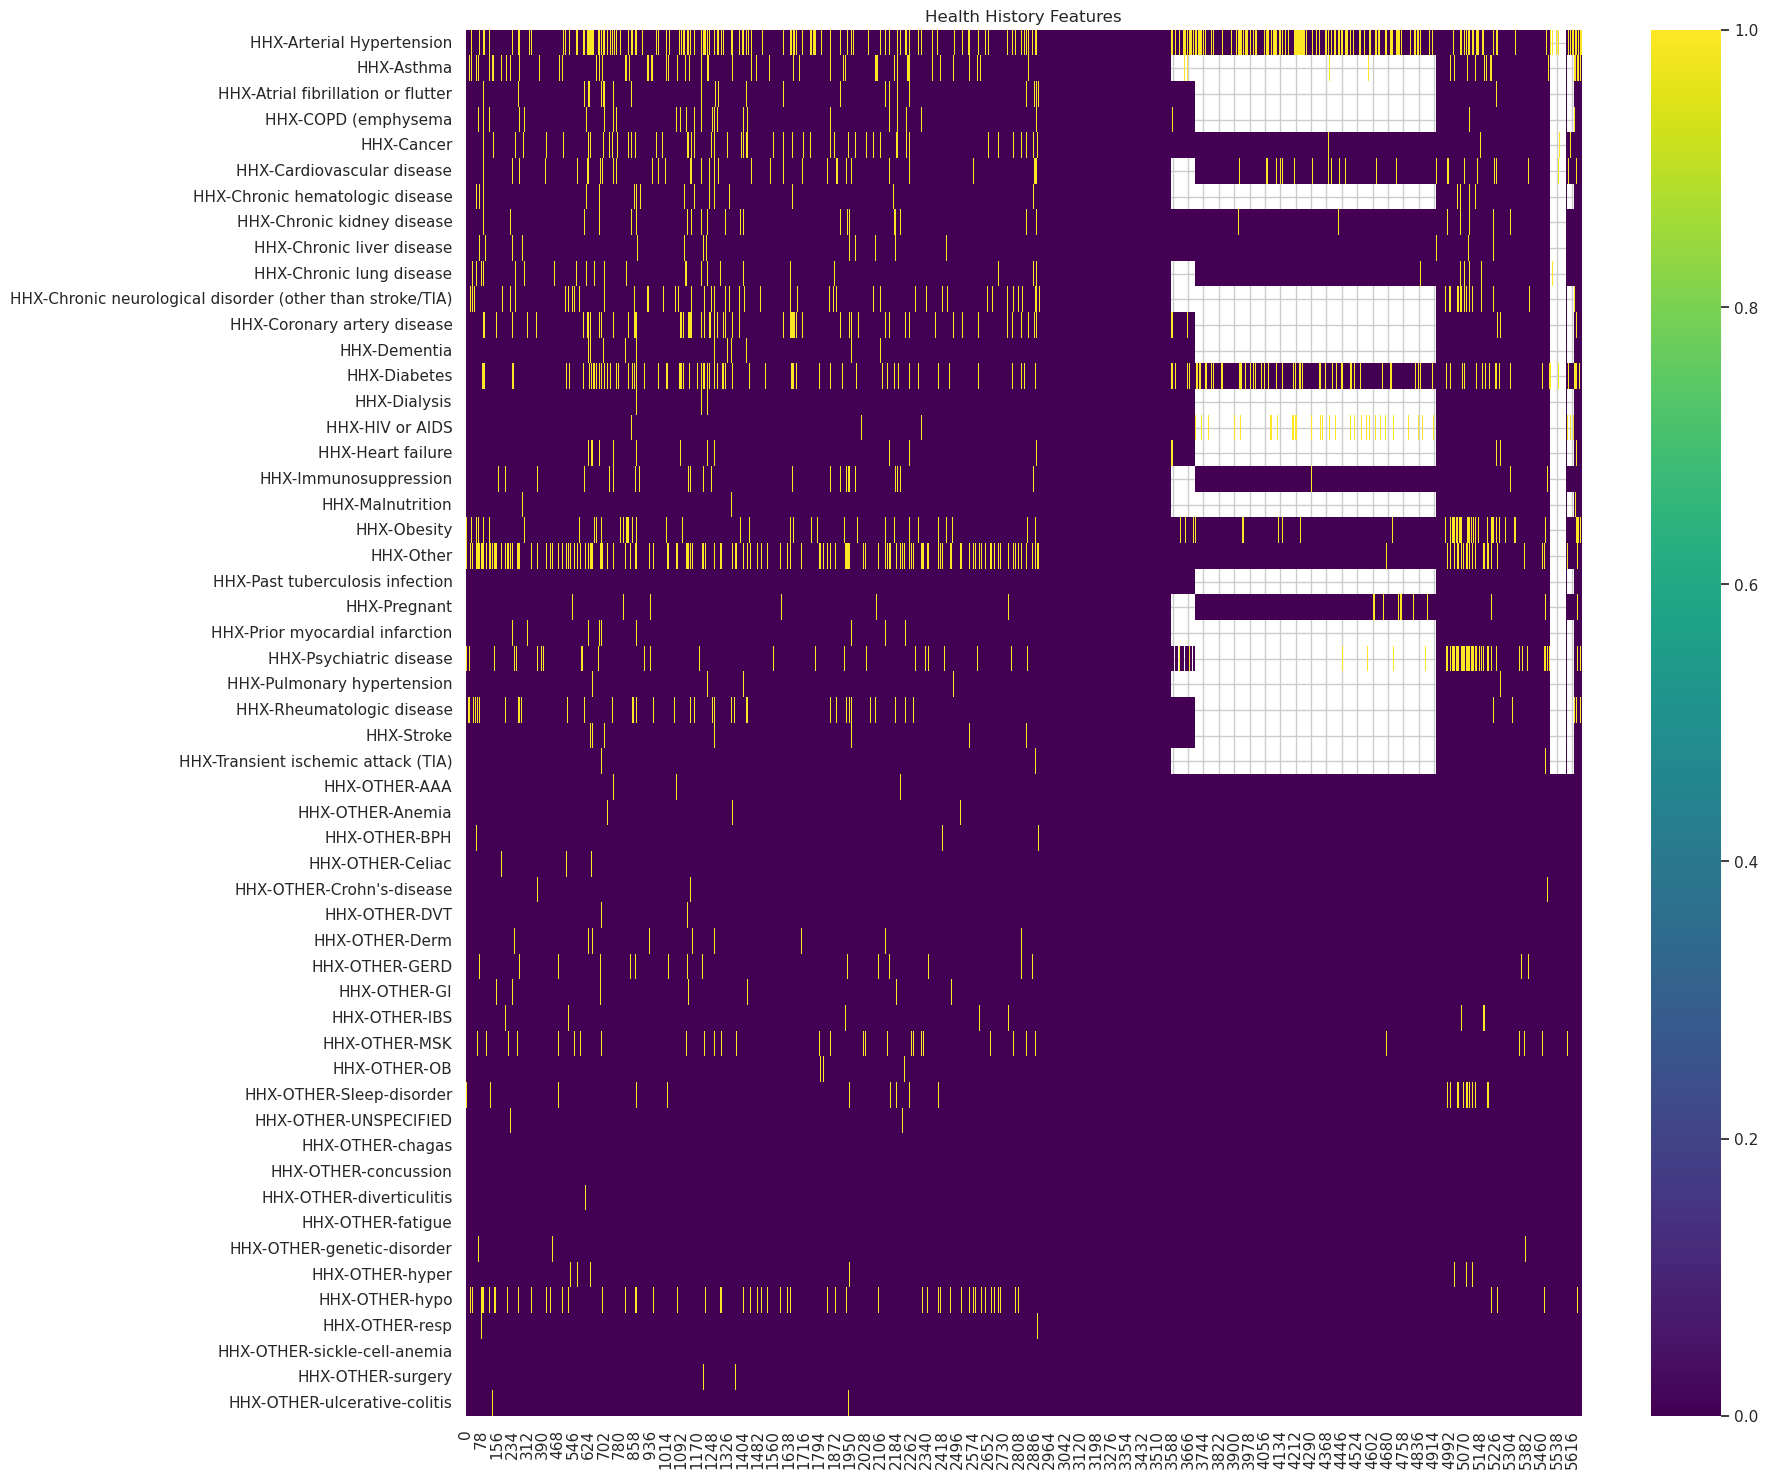

In [50]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hx_features_all.T, cbar=True, ax = ax, cmap = 'viridis')
plt.title("Health History Features")

## SURVEYS

In [51]:
# add up the health history information

# surveys
GAD    = [col for col in df_columns if "_gad" in col if "complete" not in col]
PROMIS = [col for col in df_columns if "promis29" in col]
PHQ    = [col for col in df_columns if "phq" in col]

# remove gad_complete from GAD
# it's scooped up in the above line
# GAD = [gad for gad in GAD if "complete" not in gad]

# completeness
# these columns were intermedaries and are not useful in the analysis, so we don't need these
# PHX_COMPLETE    = ["phx_complete"]
# PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]
# PHQ_COMPLETE    = [col for col in df_columns if "patient_health_questionaire" in col]

# the set of survey columns
SURVEYS = GAD + PROMIS + PHQ

In [52]:
survey_features = df[SURVEYS]
survey_features.shape

(5664, 47)

<Axes: >

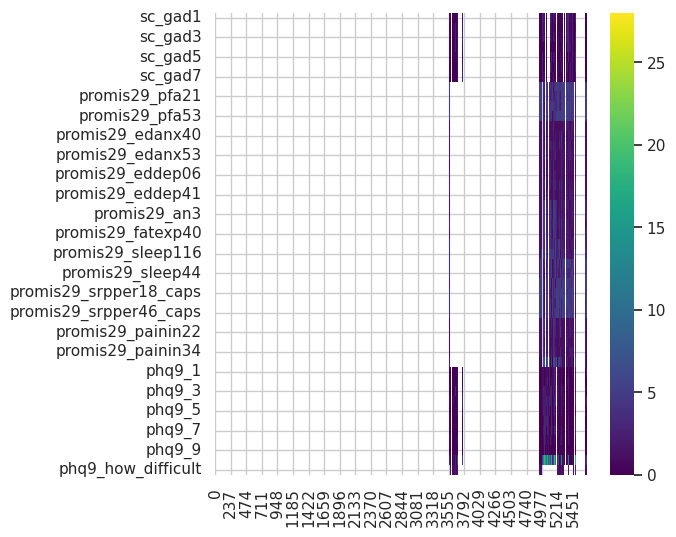

In [53]:
# plot it as a heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(survey_features.T, cbar=True, ax = ax, cmap = 'viridis')

### CONCLUSION:
- survey featureas are mostly missing, so we will not use them in the larger dataset


## SYMPTOMS

In [54]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP]



# given that the patients were asked to mark yes/no, we assume that no response is equivalent to a "no"
# QUESTION: is this reasonable?
# symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

# rename by prefixing sith SYMP
symptom_features.columns = [f"SYMPT-{col}" for col in symptom_features.columns]

# sort alphabetically
symptom_features = symptom_features.reindex(sorted(symptom_features.columns), axis=1)

symptom_features.shape

(5664, 56)

In [55]:
# how many nulls per site?
print("Missing SYMPTOM values by site:")
# df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SYMPTOM values by site:


<Axes: >

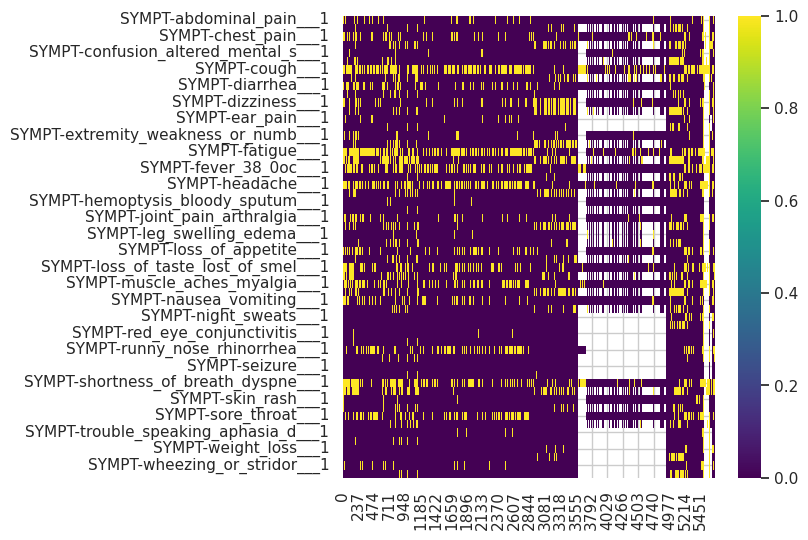

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None,cmap = 'viridis')

## CLINICAL TESTS (AKA LABS)


- all zero: lung_function, metacholine, spirometry
- consider dropping: ct*, cx*, echo*, ekg* - similarly, mostly empty
- consider dropping features with < 200 items

In [57]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")

In [58]:
# remove columns that have less than 200 non-null points
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if df[col].count() > 200]

### Investigate some of the features

In [59]:

# drop features starting with ctt and cx
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]


In [60]:
# count items that start with ct
df.filter(regex='^ct', axis = 1).count()

cta           72
ctaresult     33
ctt          292
cttresult    248
cth           73
cthresult      6
dtype: int64

In [61]:
df["ctaresult"].value_counts(), df["cttresult"].value_counts(), df["cthresult"].value_counts()

(ctaresult
 2.0    23
 0.0     7
 1.0     3
 Name: count, dtype: int64,
 cttresult
 2.0    228
 1.0     15
 0.0      5
 Name: count, dtype: int64,
 cthresult
 0.0    4
 1.0    2
 Name: count, dtype: int64)

In [62]:
# CTA, CTT, CTH - most of the results are 2 - no report
# CONCLUSION: recommend dropping these - there are very few discriminant results

In [63]:
# count items that start with ct
df.filter(regex='^cx', axis = 1).count()

cxr          327
cxrresult    260
cxrcode       38
dtype: int64

In [64]:
# count cxr code values
df["cxrresult"].value_counts()

# most are no-result. Of the 39 that are a positive finding, what are the results?

cxrresult
2.0    150
0.0     73
1.0     37
Name: count, dtype: int64

In [65]:
df["cxrcode"].value_counts()

# 33 fluid, etc
# 3 fibrosis
# 2 nodules, cysts
# 2 congestive heart disease etc

cxrcode
2.0    31
4.0     2
3.0     2
8.0     2
1.0     1
Name: count, dtype: int64

In [66]:
# CONCLUSION: recommend dropping these too - very small numbers

In [67]:
# now echo
# count items that start with ct
df.filter(regex='^echo', axis = 1).count()

echocardiogram    236
echoresult        207
dtype: int64

In [68]:
df["echoresult"].value_counts()
# mostly no reports, 7 positive findings

echoresult
2.0    166
0.0     34
1.0      7
Name: count, dtype: int64

In [69]:
# finally, ekg
print(df.filter(regex='^ekg', axis = 1).count())

print(df["ekgresult"].value_counts())

print(df["ekgcode"].value_counts())

# ekgcode results indicate 
# 10 sinus bradycardia
# 2 atrioventricular block
# 1 each of supraventricular, sinus tachy, infarction

# CONCLUSION: still recommend dropping all of the ct*, cx*, echo*, ekg* 
# numbers are very very small

ekg          252
ekgresult     63
ekgcode       17
dtype: int64
ekgresult
0.0    41
1.0    18
2.0     4
Name: count, dtype: int64
ekgcode
2.0     10
7.0      3
4.0      1
12.0     1
6.0      1
3.0      1
Name: count, dtype: int64


In [70]:
# OTHER FEATURES:
# - angiography is 7 zeroes and the rest blank
# - imaging = 12 records, imaging_results all blank
# - spirometry = 2053 records
# - spriometry_result = 27 records, of which 7 neg, 12 no report, 8 positive
# - lung_function_result = 31 records, 17 neg, 6 no report, 8 positive

In [71]:
# count all values in features
df[CLINICAL_TESTS].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   albumin              1375 non-null   float64
 1   alt                  1723 non-null   float64
 2   angiography          46 non-null     float64
 3   aptt                 580 non-null    float64
 4   ast                  1062 non-null   float64
 5   basophil             594 non-null    float64
 6   basophil_count       835 non-null    float64
 7   bilirubin            1453 non-null   float64
 8   bilirubin_direct     696 non-null    float64
 9   bnp                  18 non-null     float64
 10  cd4                  2 non-null      float64
 11  cd8                  2 non-null      float64
 12  cpk                  151 non-null    float64
 13  creatinine           1483 non-null   float64
 14  crp                  1590 non-null   float64
 15  cta                  72 non-null     f

In [72]:
# CONCLUSION SUMMARY
# drop cx*, ct*, echo*, ekg*, angiography, imaging, spiromoetry, lung_function, cd4, cd8, stented, tropinin, igg, 

In [73]:
# drop the columns
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "spirometry", "lung_function", "cd4", "cd8", "stented", "troponin", "pocus", "igg", "ntprobnp", "bnp"))]

df[CLINICAL_TESTS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   albumin           1375 non-null   float64
 1   alt               1723 non-null   float64
 2   aptt              580 non-null    float64
 3   ast               1062 non-null   float64
 4   basophil          594 non-null    float64
 5   basophil_count    835 non-null    float64
 6   bilirubin         1453 non-null   float64
 7   bilirubin_direct  696 non-null    float64
 8   cpk               151 non-null    float64
 9   creatinine        1483 non-null   float64
 10  crp               1590 non-null   float64
 11  eosinophil        548 non-null    float64
 12  eosinophil_count  836 non-null    float64
 13  ferritin          898 non-null    float64
 14  fibrinogen        758 non-null    float64
 15  glucose           1074 non-null   float64
 16  haemoglobin       1965 non-null   float64


Text(0.5, 1.0, 'Clinical Tests')

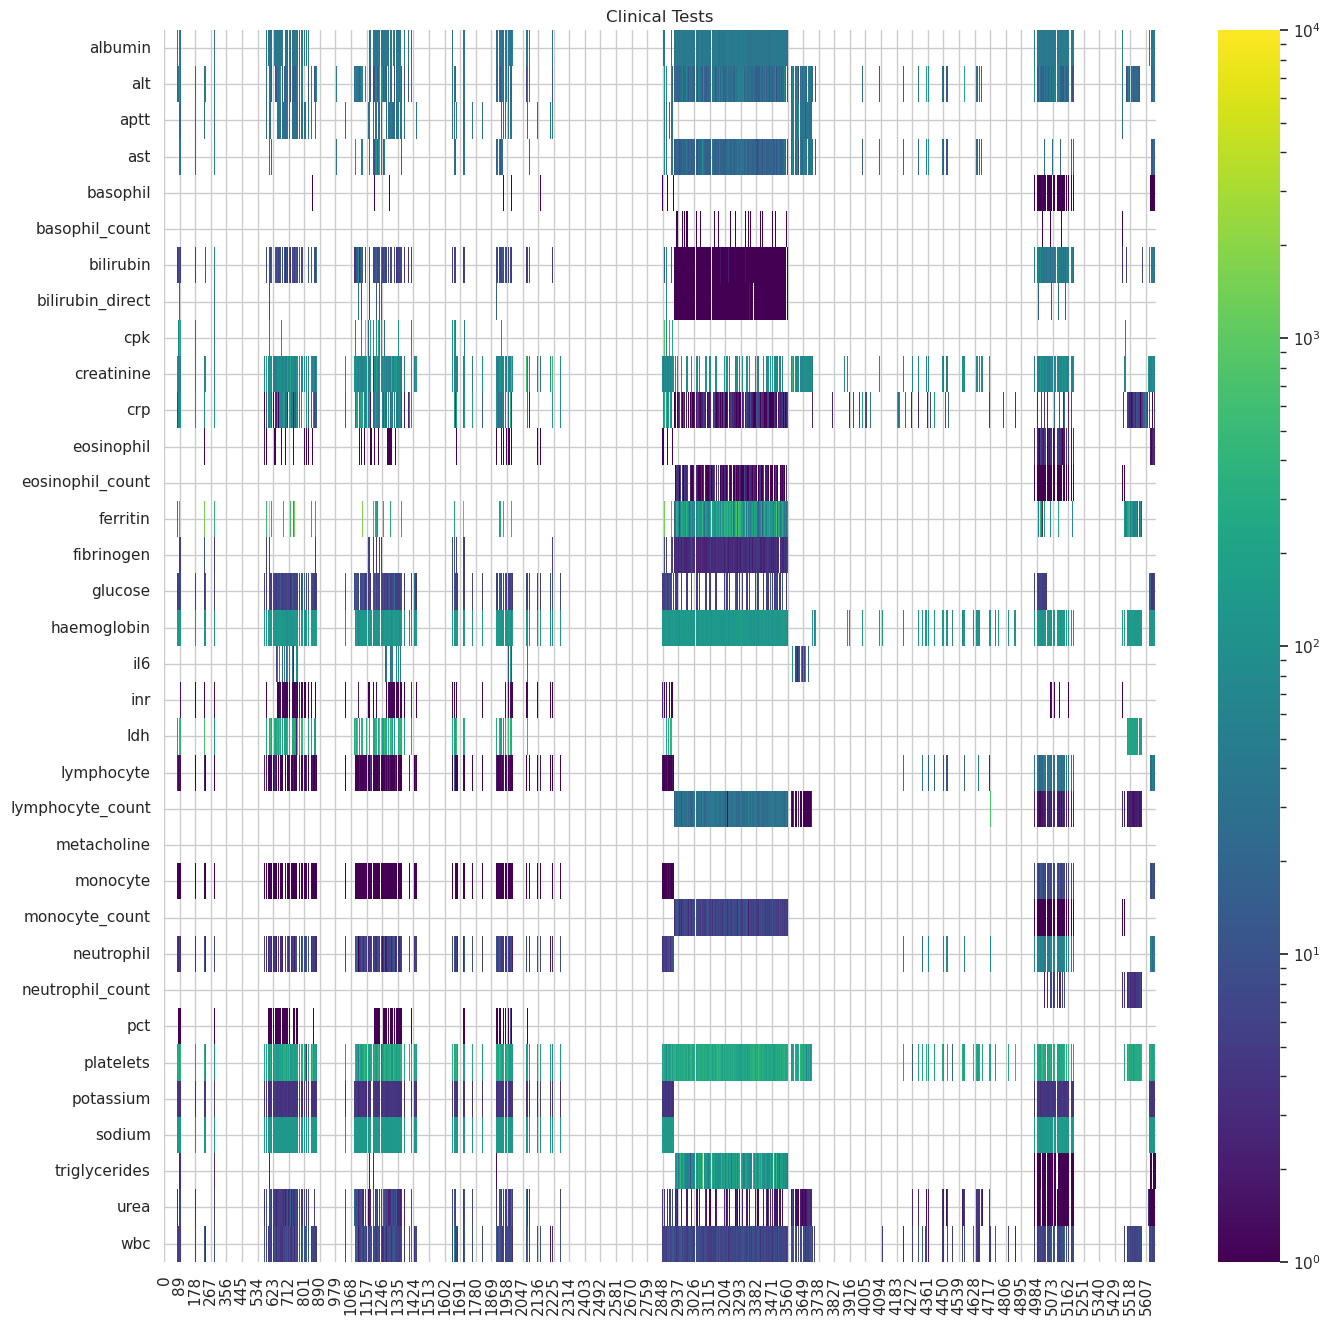

In [74]:
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm, cmap = 'viridis')
plt.title("Clinical Tests")

In [75]:
# how many nulls per site?
print("Missing CLINICAL values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.map(lambda x: f"{x:,}") # type: ignore


Missing CLINICAL values by site:


dag,LDN,MTL,SAN,RIO,LUS
albumin,315,"2,395",117,158,"1,304"
alt,246,"2,303",118,48,"1,226"
aptt,318,"2,436",340,686,"1,304"
ast,319,"2,728",279,48,"1,228"
basophil,319,"2,523",136,788,"1,304"
basophil_count,300,"2,913",162,150,"1,304"
bilirubin,313,"2,323",116,155,"1,304"
bilirubin_direct,319,"2,867",324,154,"1,304"
cpk,313,"2,768",340,788,"1,304"
creatinine,308,"2,102",110,474,"1,187"


In [76]:
# how many nulls by LC_STATUS?
print("Missing CLINICAL values by LC_STATUS:")
df.groupby('LC_STATUS')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).T.map(lambda x: f"{x:,}") # type: ignore

Missing CLINICAL values by LC_STATUS:


LC_STATUS,HC,LC_NEG,LC_POS
albumin,82,"3,084","1,123"
alt,82,"2,870",989
aptt,82,"3,011","1,991"
ast,82,"3,086","1,434"
basophil,82,"3,166","1,822"
basophil_count,82,"3,365","1,382"
bilirubin,82,"3,056","1,073"
bilirubin_direct,82,"3,334","1,552"
cpk,82,"3,283","2,148"
creatinine,82,"2,739","1,360"


In [77]:
# treat outliers before imputing data
# if we even impute the data

from project_modules.data_prep import treat_outliers
labs_without_outliers = treat_outliers(df[CLINICAL_TESTS], z_threshold = 4, method = "median")

>>> Using z-threshold = 4.00 to identify outliers.
>>> There are 208 outliers in the data for abs(z) ≥ 4.00.
>>> Outliers are 3.67% of the total data.
>>> Replacing outliers with median.


/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [78]:
labs_without_outliers.describe()

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,cpk,creatinine,...,monocyte_count,neutrophil,neutrophil_count,pct,platelets,potassium,sodium,triglycerides,urea,wbc
count,1375.000000,1723.000000,580.000000,1062.000000,594.000000,835.000000,1453.000000,696.000000,151.000000,1483.000000,...,836.000000,1027.000000,154.000000,363.000000,2032.000000,1051.000000,1052.000000,857.000000,1272.000000,2047.000000
mean,39.699200,37.192362,32.917483,32.113465,0.143939,0.102635,12.721115,1.521121,387.033113,93.430057,...,6.036124,18.923439,4.369740,0.395234,252.561220,4.101047,137.638783,108.307468,4.639952,7.553542
std,14.666102,37.992112,13.793910,33.299356,0.213077,0.302813,27.414287,5.689268,1024.353601,88.521757,...,17.316756,23.422936,1.648321,1.134721,96.616367,0.635886,4.257946,120.745627,4.833092,3.964776
min,17.000000,5.000000,1.400000,1.600000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,...,0.000000,0.600000,1.400000,0.020000,1.000000,2.200000,115.000000,0.100000,0.300000,1.000000
25%,37.000000,19.000000,27.275000,17.000000,0.000000,0.000000,0.500000,0.100000,52.500000,62.000000,...,3.000000,4.100000,3.192500,0.080000,190.000000,3.800000,136.000000,1.700000,1.610000,5.400000
50%,40.000000,27.000000,31.550000,23.000000,0.000000,0.000000,5.000000,0.100000,107.000000,78.000000,...,6.000000,6.500000,4.210000,0.130000,243.000000,4.100000,138.000000,92.000000,3.300000,6.900000
75%,42.000000,42.000000,35.425000,34.000000,0.275000,0.000000,12.000000,0.100000,275.500000,95.745000,...,8.000000,19.000000,5.100000,0.250000,304.000000,4.400000,140.000000,151.000000,5.800000,8.800000
max,404.000000,921.000000,240.000000,478.600000,1.400000,2.000000,680.700000,53.000000,9650.000000,1192.000000,...,496.800000,86.900000,11.060000,11.750000,1480.000000,13.300000,160.000000,1589.000000,36.900000,81.700000


### consider imputing the labs data, by sex and by site

<Axes: xlabel='dag'>

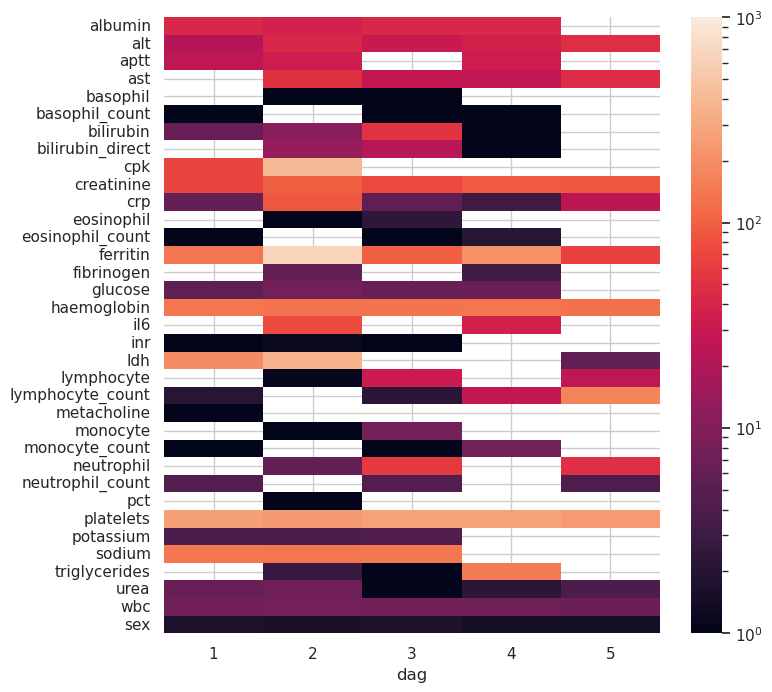

In [79]:
# given the labs_without_outliers, we need to add sex and site back in
# we also need to add in the LC_STATUS column

t1 = pd.concat([labs_without_outliers, df[["sex", "dag"]]
                ], axis = 1)

norm = mc.LogNorm(vmin=1, vmax=1_000)

# get means by site
sns.heatmap(t1.groupby("dag").mean().T, norm = norm)



<Axes: xlabel='dag', ylabel='haemoglobin'>

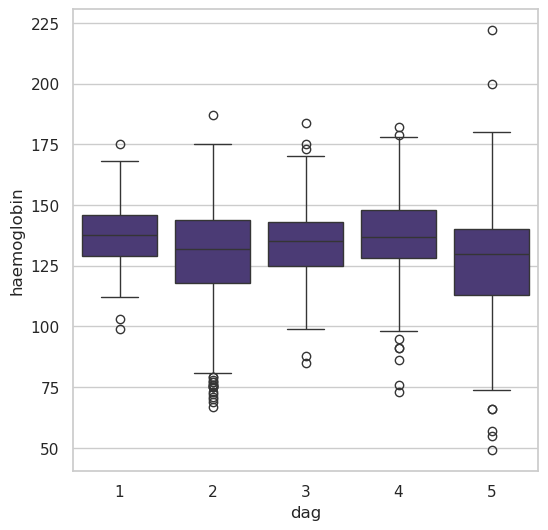

In [80]:
# haemoglobin values look odd in a table DT made
# let's have a look

# plot haemoglobin by site
fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data = t1, x = "dag", y = "haemoglobin", ax = ax)

In [ ]:
# simple unit check
# hameoglobin is specified in diction as [g L^-1]
# normal range is 130-180 [g L^-1]
# LUSAKA values are in the 10s, so must be in [g dL^-1]
# convert to [g L^-1]

# find the LUSAKA values
lusaka_haemoglobin = t1.query('dag == 5')["haemoglobin"]

# convert to [g L^-1]
lusaka_haemoglobin = lusaka_haemoglobin * 10

lusaka_haemoglobin.describe()

# now we can see that the values are in the normal range

# replace the values in the dataframe
t1.loc[t1["dag"] == 5, "haemoglobin"] = lusaka_haemoglobin


<Axes: xlabel='dag', ylabel='haemoglobin'>

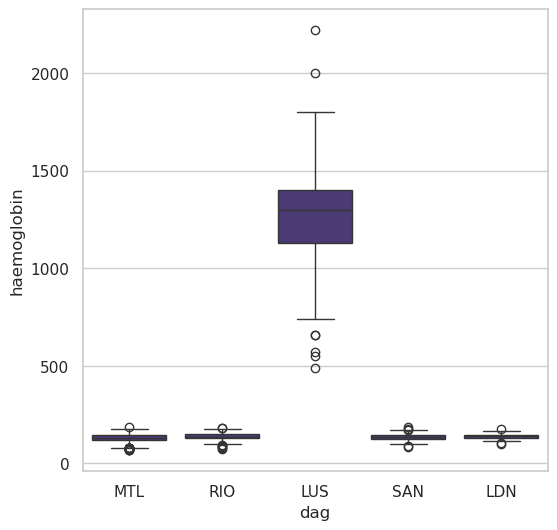

In [ ]:
# haemoglobin values look odd in a table DT made
# let's have a look

# plot haemoglobin by site
fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(data = t1, x = t1["dag"].map(site_name_dict), y = "haemoglobin", ax = ax)

In [ ]:
                                 
# group by sex and dag
t2 = t1.groupby(["sex", "dag"]).transform(lambda x: x.fillna(x.median()))


/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/num

In [ ]:
t2

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,cpk,creatinine,...,monocyte_count,neutrophil,neutrophil_count,pct,platelets,potassium,sodium,triglycerides,urea,wbc
0,37.0,23.0,30.7,35.0,0.0,NaN,7.00,5.05,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.4000,6.60
1,36.0,32.0,31.7,39.0,0.0,NaN,10.00,10.65,164.5,86.000,...,NaN,5.70,NaN,0.15,210.0,4.0,137.0,1.70,6.0000,7.30
2,37.0,23.0,30.7,35.0,0.0,NaN,7.00,5.05,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.4000,6.60
3,37.0,23.0,30.7,35.0,0.0,NaN,7.00,5.05,65.0,64.000,...,NaN,4.80,NaN,0.10,228.0,3.9,138.0,2.55,4.4000,6.60
4,36.0,32.0,31.7,39.0,0.0,NaN,10.00,10.65,164.5,86.000,...,NaN,5.70,NaN,0.15,210.0,4.0,137.0,1.70,6.0000,7.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,44.0,30.0,NaN,20.0,0.4,0.0,44.20,17.70,NaN,96.356,...,0.6,59.85,4.505,NaN,233.0,4.6,142.0,0.40,0.6660,6.90
5660,38.0,17.0,NaN,13.0,0.2,0.0,35.40,22.10,NaN,63.648,...,0.5,74.00,4.065,NaN,405.0,4.5,138.0,0.40,0.6105,13.88
5661,42.0,30.5,NaN,27.0,0.4,0.0,44.20,17.70,NaN,82.200,...,0.6,59.85,4.505,NaN,233.0,4.2,140.0,0.30,0.8000,6.90
5662,43.0,24.0,NaN,24.0,0.4,0.0,70.72,17.70,NaN,146.744,...,0.6,59.85,4.505,NaN,233.0,4.9,138.0,0.40,2.3310,6.90


<Axes: >

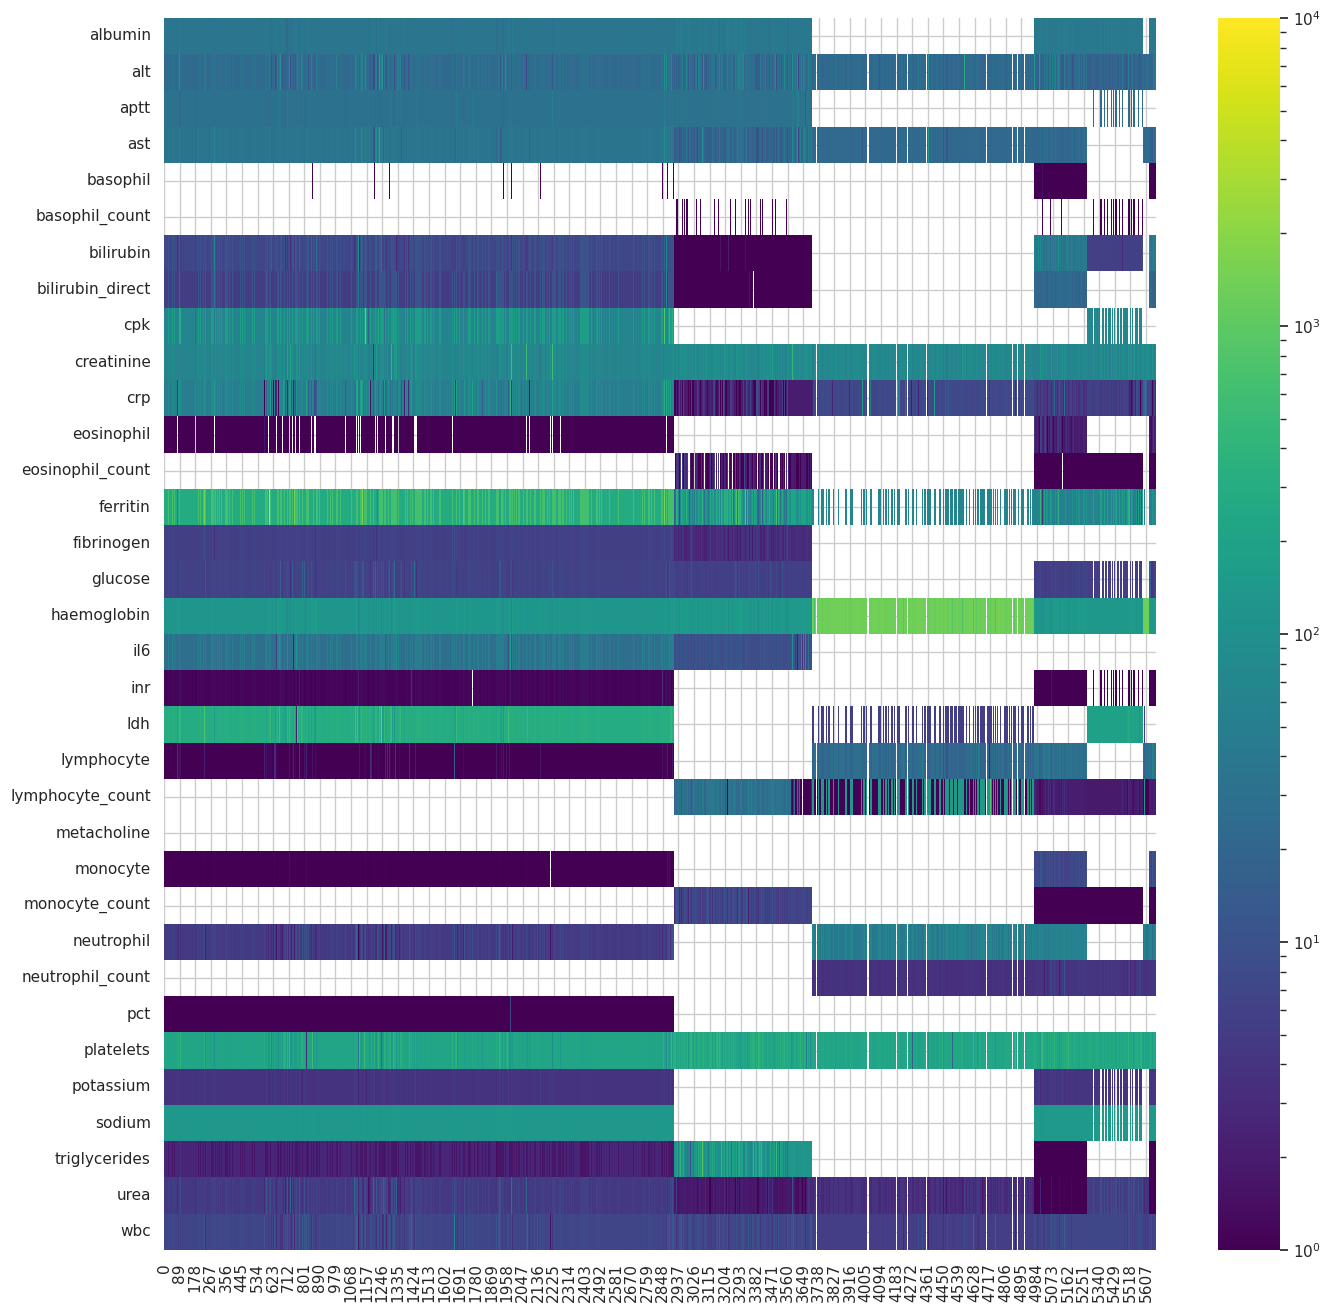

In [ ]:
# heatmap
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [ ]:
# are there records that are entirely nan?
t2[t2.isna().all(axis = 1)]
t2.dropna(how = 'all', inplace = True)

<Axes: >

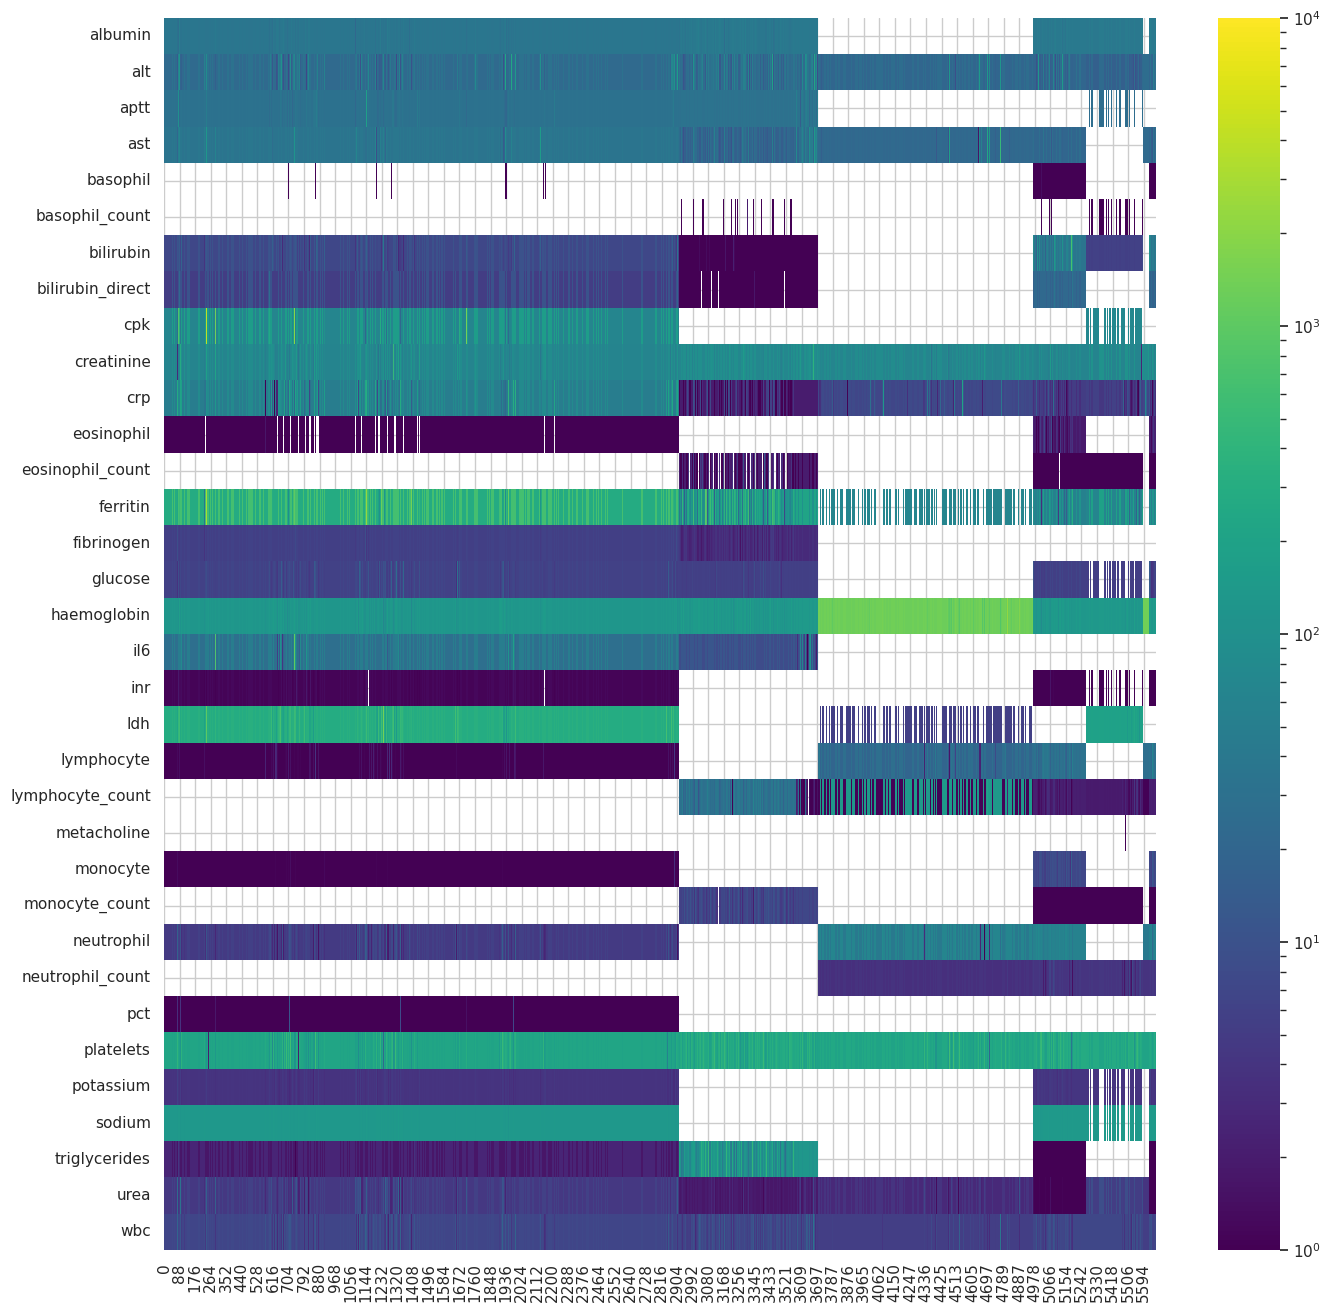

In [ ]:
# heatmap
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

<Axes: >

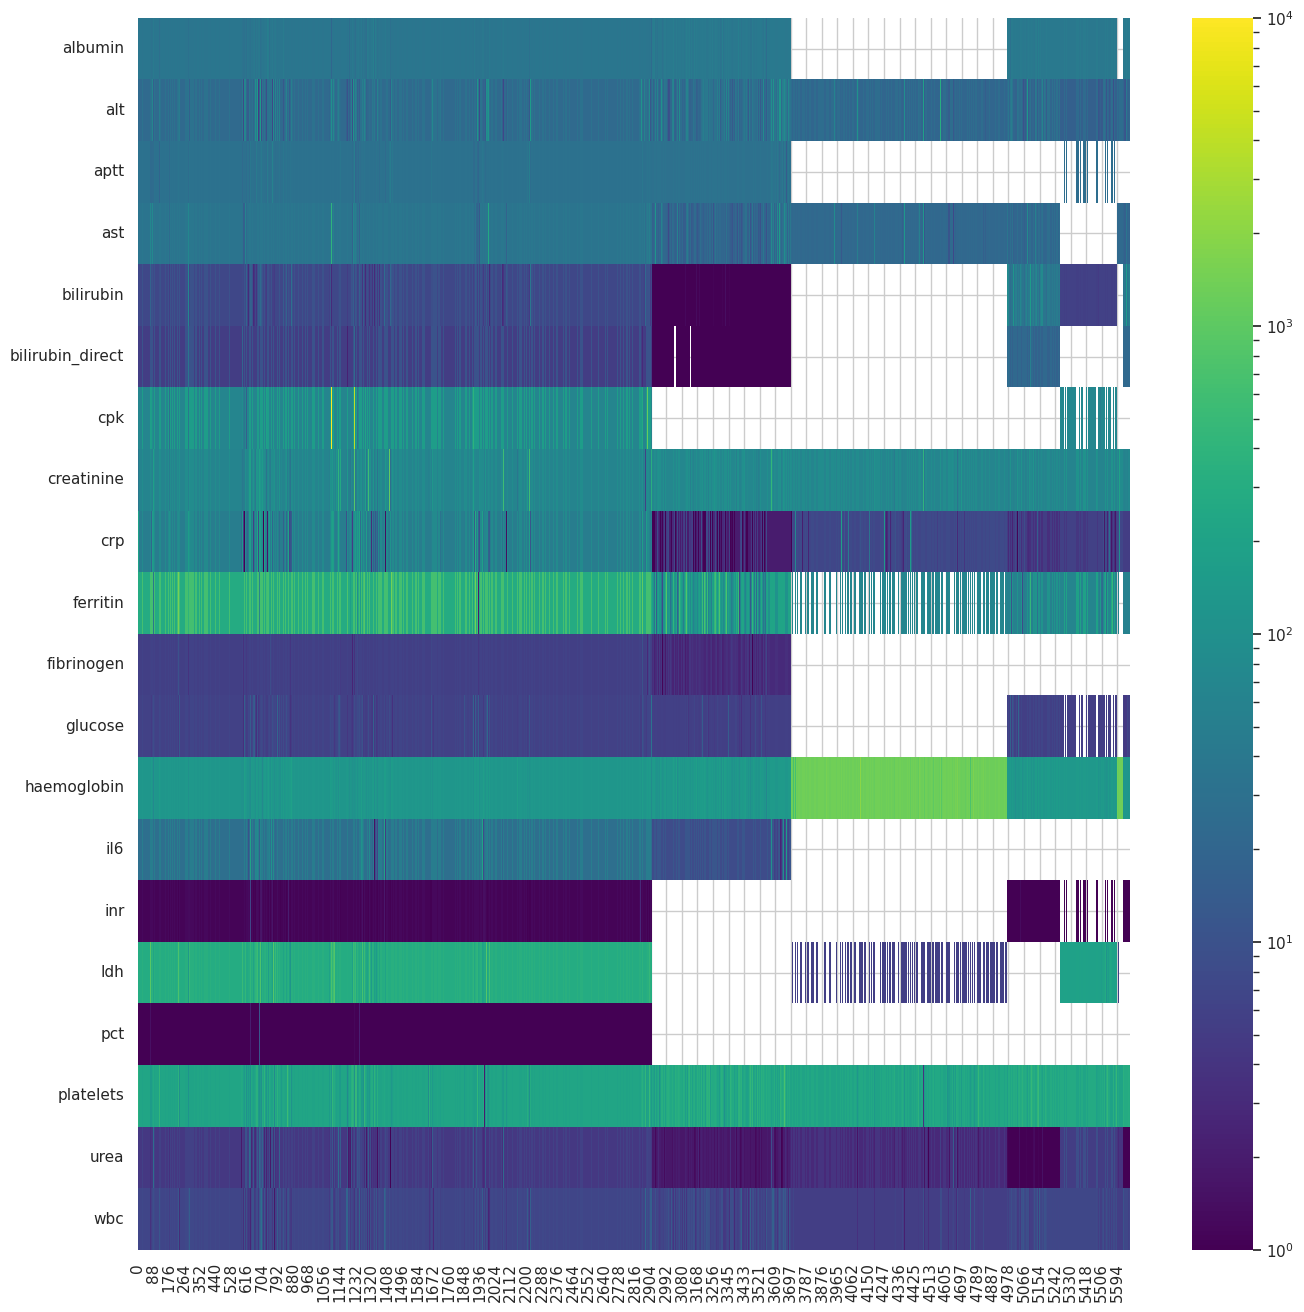

In [ ]:
# drop some additional labs

CT2 = [col for col in CLINICAL_TESTS if not col.startswith(("eos", "meta", "m,ono", "neutro","potas","sodiu", "tri", "baso", "mono", "lymph"))]

t3 = t2[CT2]

# heatmap
fig, ax = plt.subplots(figsize=(16,16))

norm = mc.LogNorm(vmin=1, vmax=10_000)

sns.heatmap(t3.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [ ]:
# which features have a complete set of data (no missing values)?

complete_features = t3.dropna(axis = 1, how = 'any')
complete_features

,alt,creatinine,crp,haemoglobin,platelets,urea,wbc
0,23.0,64.000,48.60,125.0,228.0,4.4000,6.60
1,32.0,86.000,79.30,138.0,210.0,6.0000,7.30
2,23.0,64.000,48.60,125.0,228.0,4.4000,6.60
3,23.0,64.000,48.60,125.0,228.0,4.4000,6.60
4,32.0,86.000,79.30,138.0,210.0,6.0000,7.30
...,...,...,...,...,...,...,...
5659,30.0,96.356,3.50,149.0,233.0,0.6660,6.90
5660,17.0,63.648,5.15,113.0,405.0,0.6105,13.88
5661,30.5,82.200,3.50,149.0,233.0,0.8000,6.90
5662,24.0,146.744,3.50,149.0,233.0,2.3310,6.90


In [ ]:
# # sklearn median imputer

# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='median')

# clinical_test_features = b.copy()

# ctf_imputed = pd.DataFrame(imp.fit_transform(clinical_test_features), columns = clinical_test_features.columns)

# print(ctf_imputed.shape)


# clin_test_features = ctf_imputed
# # rename the columns with CLIN- prefix
# clin_test_features.columns = [f"CLIN-{col}" for col in clin_test_features.columns]


# # plot the heatmap
# fig, ax = plt.subplots(figsize=(16, 16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(clin_test_features.T, cbar=True, ax = ax, norm = norm)
# # set text size smaller
# plt.xticks(fontsize=8); plt.yticks(fontsize=8);
# plt.title("Clinical Tests - Imputed with Median")


# # find columns that are all zero
# all_zero = clin_test_features.columns[(clin_test_features == 0).all()]

# print(all_zero)

# # drop the all zero columns
# clin_test_features = clin_test_features.drop(columns = all_zero)

In [ ]:
t1

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,cpk,creatinine,...,neutrophil_count,pct,platelets,potassium,sodium,triglycerides,urea,wbc,sex,dag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,44.0,30.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,96.356,...,NaN,NaN,NaN,4.6,142.0,0.4,0.6660,NaN,1.0,3
5660,38.0,17.0,NaN,13.0,0.2,NaN,NaN,NaN,NaN,63.648,...,NaN,NaN,405.0,4.5,138.0,NaN,0.6105,13.88,2.0,3
5661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,1.0,3
5662,43.0,24.0,NaN,24.0,NaN,NaN,70.72,NaN,NaN,146.744,...,NaN,NaN,NaN,4.9,138.0,NaN,2.3310,NaN,1.0,3


In [ ]:
# WIP: DO NOT IMPUTE

# no imputation
# lab_features = labs_without_outliers

# no imputation, fixed LUS haemo values
lab_features = t1.drop(["sex", "dag"], axis = 1)


# EXPT: use the reduced set of labs
# lab_features = complete_features

# rename the colummns by prefixing with LABS
lab_features.columns = [f"LABS-{col}" for col in lab_features.columns]

lab_features.shape

(5664, 34)

In [ ]:
lab_features.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LABS-albumin           1375 non-null   float64
 1   LABS-alt               1723 non-null   float64
 2   LABS-aptt              580 non-null    float64
 3   LABS-ast               1062 non-null   float64
 4   LABS-basophil          594 non-null    float64
 5   LABS-basophil_count    835 non-null    float64
 6   LABS-bilirubin         1453 non-null   float64
 7   LABS-bilirubin_direct  696 non-null    float64
 8   LABS-cpk               151 non-null    float64
 9   LABS-creatinine        1483 non-null   float64
 10  LABS-crp               1590 non-null   float64
 11  LABS-eosinophil        548 non-null    float64
 12  LABS-eosinophil_count  836 non-null    float64
 13  LABS-ferritin          898 non-null    float64
 14  LABS-fibrinogen        758 non-null    float64
 15  LABS

## CLINICAL DETAILS

In [ ]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-clin-details.json", "r") as f:
    cd_list = json.load(f)

# get all columns that start with the symptoms list
CD = [col for col in df.columns if  col.startswith(tuple(cd_list))]

# delete items that sstart with phx and phq
# the are scooped up by accident because cd_list contains "ph"
CD = [col for col in CD if not col.startswith(("phx", "phq"))]

# feature set for symptoms
cd_features = df[CD]

# preprend CLIN- to the column names
cd_features.columns = [f"CD-{col}" for col in cd_features.columns]

# find spaces in the data and replace with zero
cd_features = cd_features.replace(" ", 0)

/tmp/ipykernel_26286/2295893641.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd_features = cd_features.replace(" ", 0)


In [ ]:
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 320 entries, CD-pregnant to CD-o2_saturation
dtypes: datetime64[ns](5), float64(310), object(5)
memory usage: 13.8+ MB


In [ ]:
# drop columns with dtype datetime64
cd_features = cd_features.select_dtypes(exclude = ['datetime64'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 315 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310), object(5)
memory usage: 13.6+ MB


In [ ]:
# which cols are of type object?
cd_features.select_dtypes(include = ['object']).columns

Index(['CD-delivery_date_actual', 'CD-covid_test_date_1',
       'CD-date_of_hospitalization', 'CD-date_of_discharge',
       'CD-specify_other_med'],
      dtype='object')

In [ ]:
# drop the object columns as they are either dates or mostly spaces
cd_features = cd_features.select_dtypes(exclude = ['object'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 310 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310)
memory usage: 13.4 MB


Text(0.5, 1.0, 'CLINICAL DETAIL Status- missing values are light coloured')

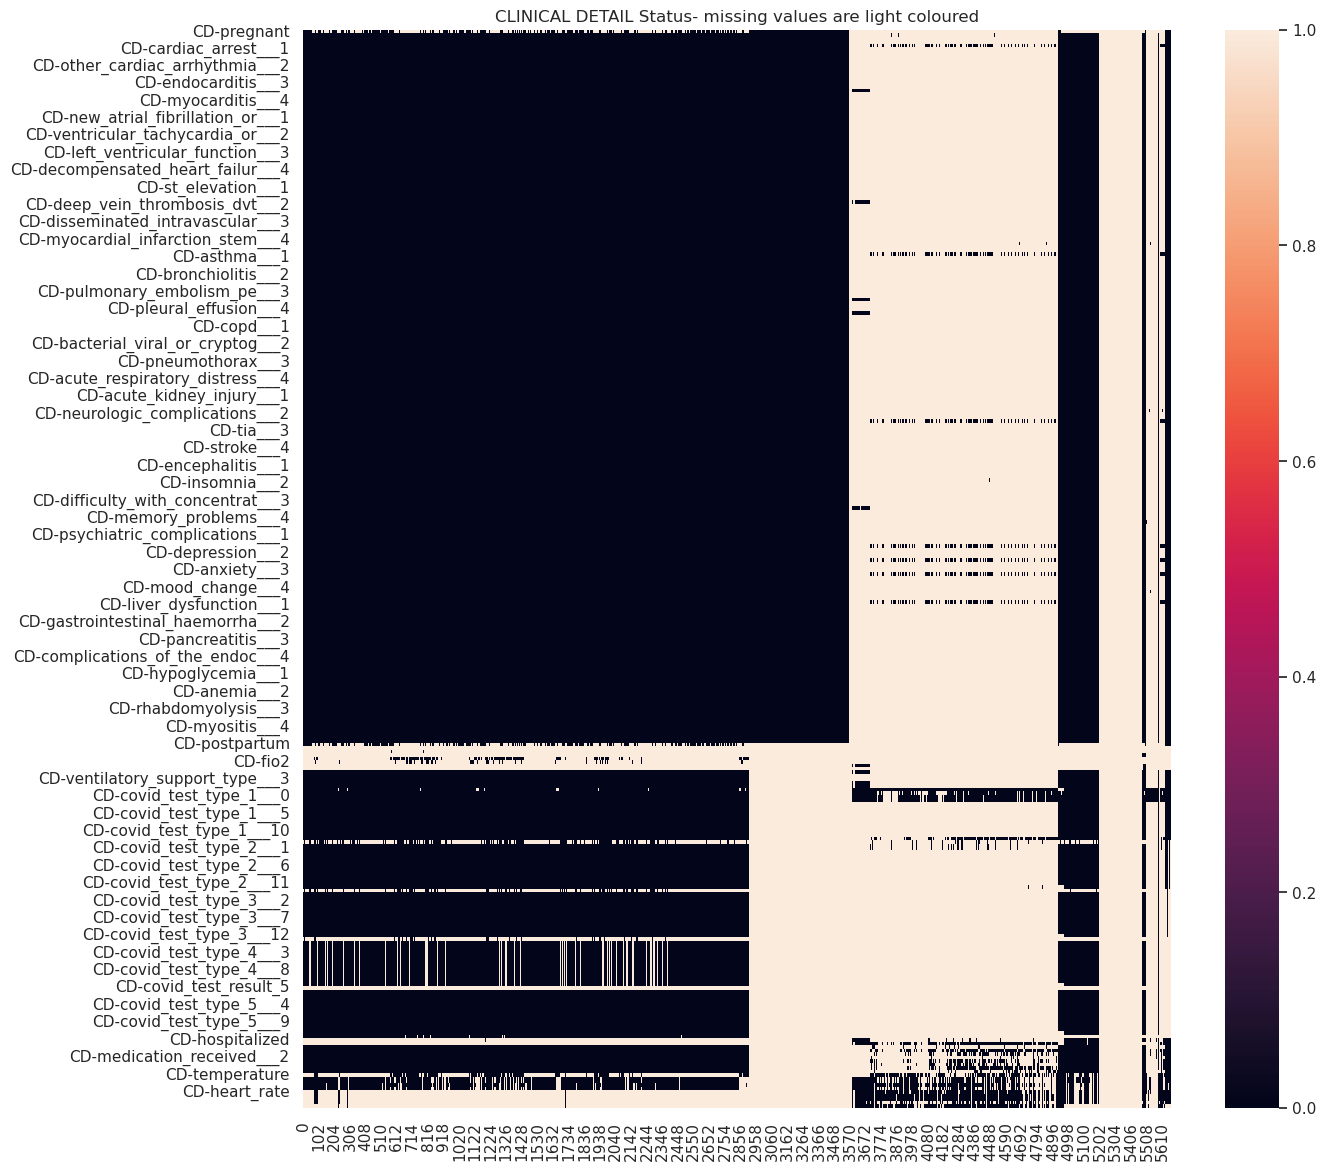

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CLINICAL DETAIL Status- missing values are light coloured")

In [ ]:
# these features are not very informative - consider dropping them
cd_features = cd_features.drop(columns = cd_features.filter(like = "test_type").columns)

# height in metres and centimetres is redundant
# drop the height in cm
cd_features = cd_features.drop(columns = "CD-height_cm")

cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 244 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(244)
memory usage: 10.5 MB


In [ ]:
# sort alphabetically
cd_features = cd_features.reindex(sorted(cd_features.columns), axis=1)

Text(0.5, 1.0, 'CLINICAL DETAIL Status - missing values are light coloured')

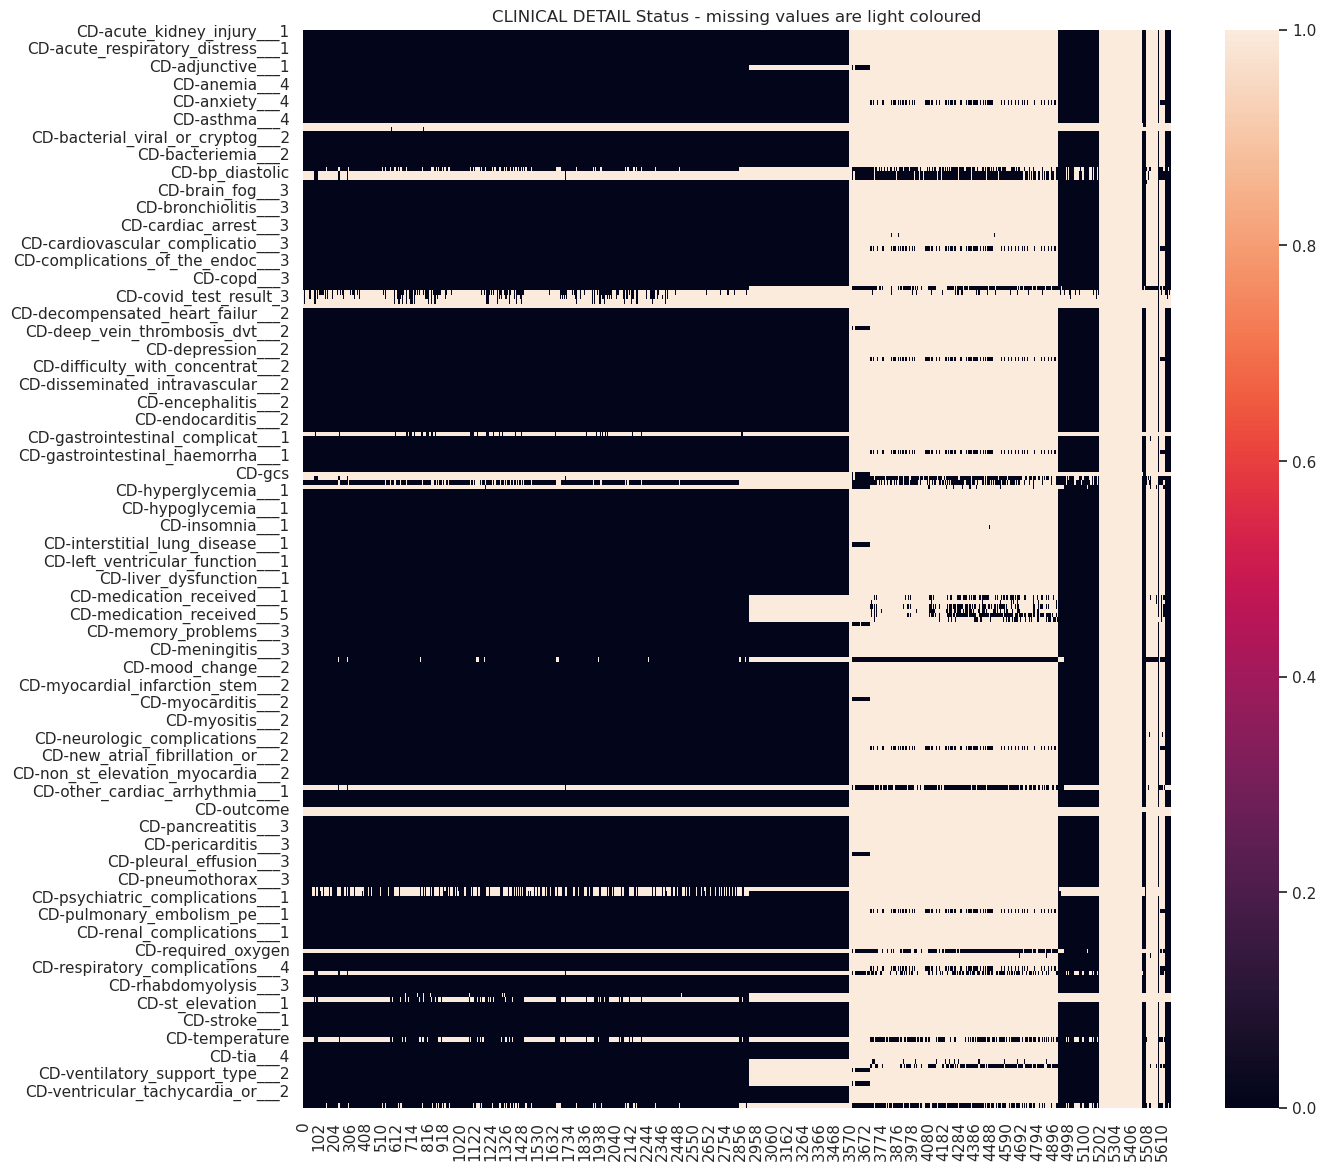

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CLINICAL DETAIL Status - missing values are light coloured")

In [ ]:
# missing values by site
print("Missing CLINICAL DETAILS values by site:")

cd_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing CLINICAL DETAILS values by site:


dag,LDN,MTL,SAN,RIO,LUS
CD-acute_kidney_injury___1,288,0,74,137,1258
CD-acute_kidney_injury___2,288,0,74,137,1258
CD-acute_kidney_injury___3,288,0,74,137,1258
CD-acute_kidney_injury___4,288,0,74,137,1258
CD-acute_respiratory_distress___1,288,0,74,137,1258
...,...,...,...,...,...
CD-ventricular_tachycardia_or___1,288,0,74,137,1258
CD-ventricular_tachycardia_or___2,288,0,74,137,1258
CD-ventricular_tachycardia_or___3,288,0,74,137,1258
CD-ventricular_tachycardia_or___4,288,0,74,137,1258


## VACCINES

In [ ]:
# patient vaccination status
VAX_STATUS = ["vaccinated"]

# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

# unstructured text - save for later analysis
VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# QUESTION: is the assumption to fill blank values with 0 correct?
# df[VAX] = df[VAX].fillna(0)

# use all features
# vax_features = df[VAX_STATUS + VAX]

# for now, select only vaccine status
vax_features = df[VAX_STATUS]

print(vax_features.shape)

# prefix VAX- to the column names
vax_features.columns = [f"VAX-{col}" for col in vax_features.columns]


(5664, 1)


In [ ]:
vvv = pd.concat([df[VAX], df['dag']], axis = 1)

In [ ]:
vl = vvv.groupby('dag').sum().T.sum()
vl

dag
1     462.0
2    6958.0
3    1081.0
4    1792.0
5     383.0
dtype: float64

In [ ]:
pd.concat([vax_features, df['dag']], axis = 1).groupby('dag').sum().T.sum()

dag
1     155.0
2    2849.0
3     322.0
4     747.0
5     311.0
dtype: float64

In [ ]:
# how many rows with dag = 5?
vvv.query('dag == 5').shape

(1304, 71)

In [ ]:
# get a subset of vvv for dag = 5
vl = vvv.query('dag == 5').head()

# how many nans per column?
vl.isnull().sum()


astra_zeneca___1    5
astra_zeneca___2    5
astra_zeneca___3    5
astra_zeneca___4    5
astra_zeneca___5    5
                   ..
other___7           5
other___8           5
other___9           5
other___10          5
dag                 0
Length: 71, dtype: int64

In [ ]:
vl

,astra_zeneca___1,astra_zeneca___2,astra_zeneca___3,astra_zeneca___4,astra_zeneca___5,astra_zeneca___6,astra_zeneca___7,astra_zeneca___8,astra_zeneca___9,astra_zeneca___10,...,other___2,other___3,other___4,other___5,other___6,other___7,other___8,other___9,other___10,dag
3701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [ ]:
# count non-zero values per dag
vvv.groupby(df['dag']).apply(lambda x: x.astype(bool).sum(axis=0)).rename(index = site_name_dict)

,astra_zeneca___1,astra_zeneca___2,astra_zeneca___3,astra_zeneca___4,astra_zeneca___5,astra_zeneca___6,astra_zeneca___7,astra_zeneca___8,astra_zeneca___9,astra_zeneca___10,...,other___2,other___3,other___4,other___5,other___6,other___7,other___8,other___9,other___10,dag
dag,,,,,,,,,,,,,,,,,,,,,
LDN,83,81,81,81,81,81,81,81,81,81,...,83,82,82,82,81,81,81,81,81,319
MTL,150,0,0,0,0,0,0,0,0,0,...,1403,1365,411,276,1,0,0,0,0,2913
SAN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,340
RIO,354,341,116,222,121,121,121,121,121,121,...,121,121,121,121,121,121,121,121,121,788
LUS,1272,1268,1258,1258,1258,1258,1258,1258,1258,1258,...,1258,1258,1258,1258,1258,1258,1258,1258,1258,1304


Text(0.5, 1.0, 'Vaccination Status - missing values are light coloured')

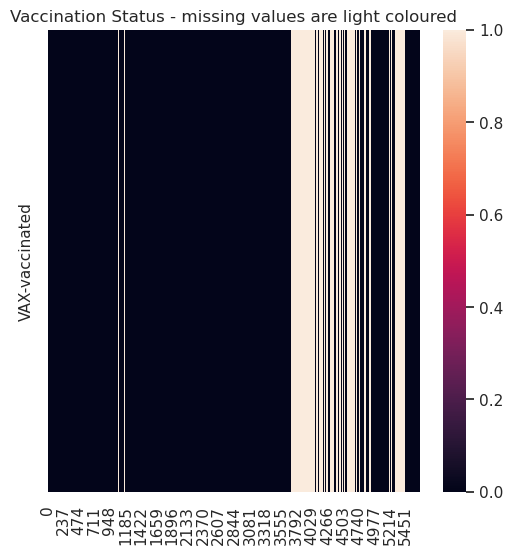

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(vax_features.isnull().T, cbar=True, ax = ax, )
plt.title("Vaccination Status - missing values are light coloured")

In [ ]:
# how many missing values per dag?
print("Missing VAX values by site:")
vax_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing VAX values by site:


dag,LDN,MTL,SAN,RIO,LUS
VAX-vaccinated,158,41,7,0,931


In [ ]:
# # how many nulls per site?
# print("Missing VACCINE values by site:")
# df.groupby('dag')[VAX + VAX_STATUS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


### CONCLUSION:
- use only the vaccine status (binary)

# SAVE FEATURES TO FILE

- fill  na with 0 in vax, symptoms
- 

In [ ]:
# demographic_features
# medication_features
# hx_features_all
# survey_features
# symptom_features
# clinical_features
# vax_features

# concatenate all of the features
features = pd.concat([
                        demographic_features, 
                        medication_features, 
                        symptom_features, 
                        vax_features,
                        hx_features_all, 
                        lab_features, 
                        cd_features,
                        substance_features, #selected by MP for now
                        # WIP: 
                        # none
                        # NOT SELECTED:
                        # survey_features,    # not selected
                      ], axis = 1)

features["LC_STATUS"] = df["LC_STATUS"]

In [ ]:
features.shape

(5664, 426)

In [ ]:
# count the nulls per site
print("Missing values by site:")

features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()

Missing values by site:


/tmp/ipykernel_26286/4098030052.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()


dag
LDN     86961
MTL    141647
SAN     29503
RIO     78884
LUS    395255
dtype: int64

Text(0.5, 1.0, 'Missing values - light coloured cells are missing')

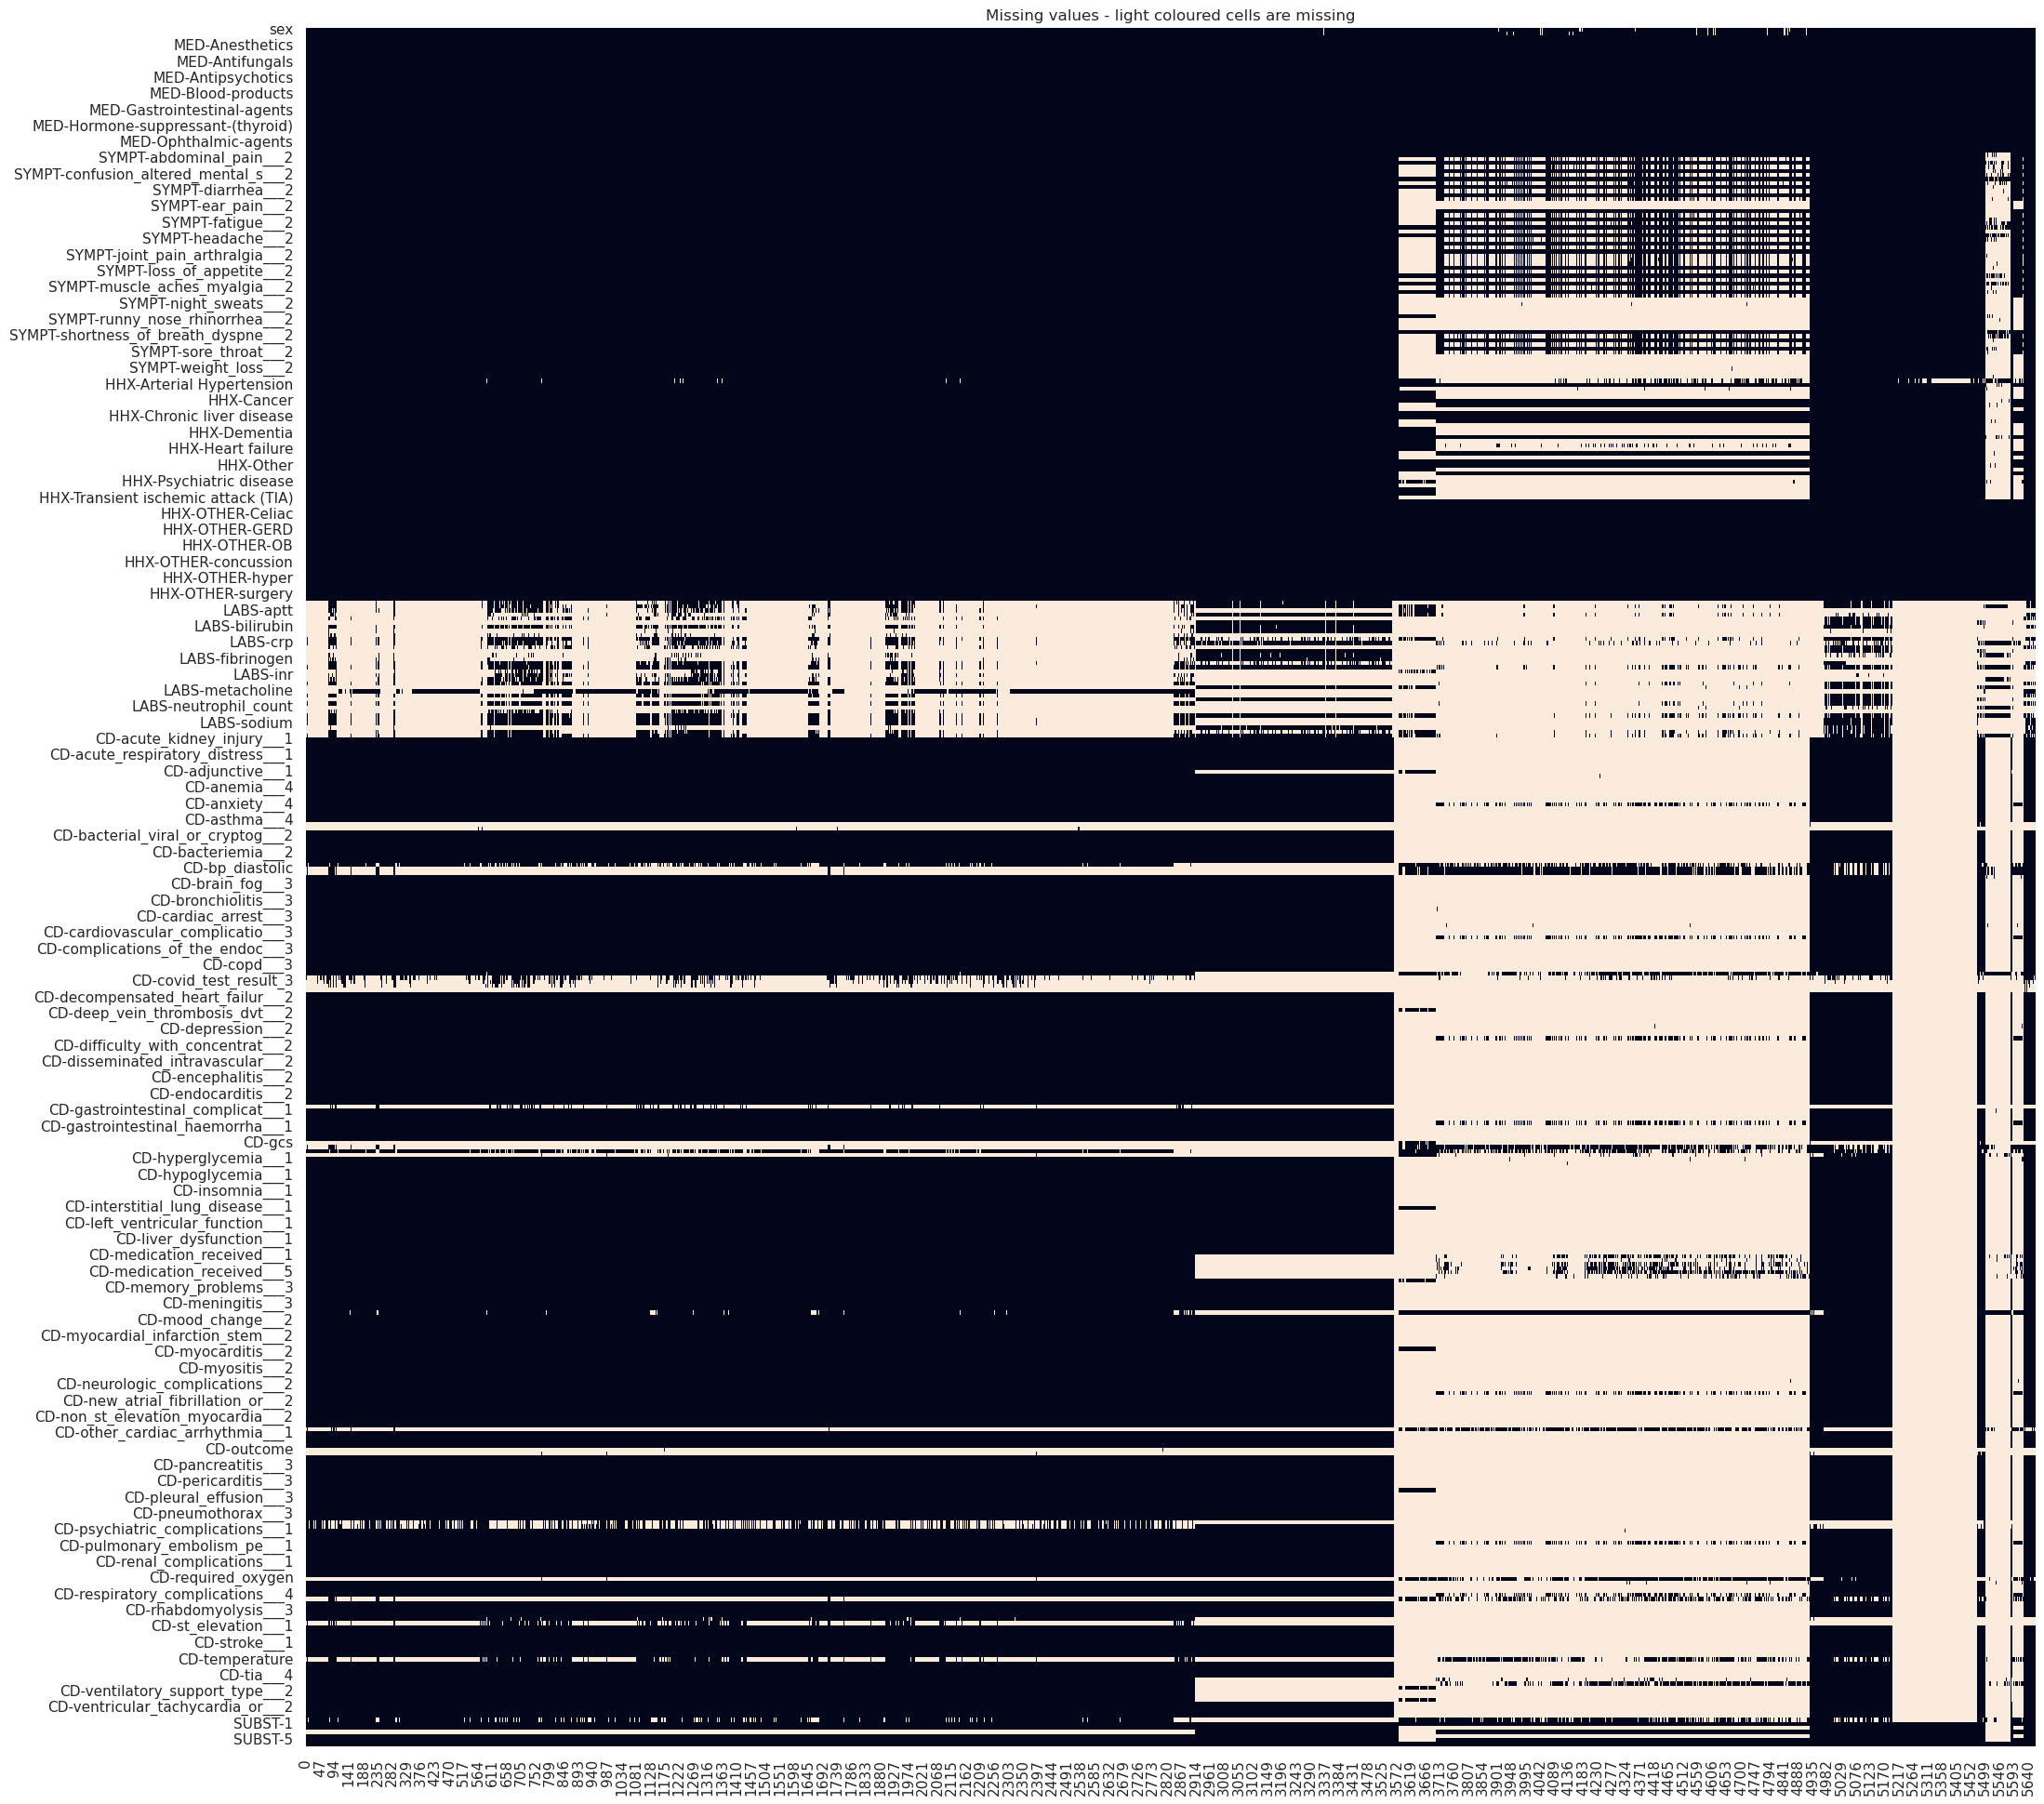

In [ ]:
fig, ax = plt.subplots(figsize=(24, 24))

sns.heatmap(features.isnull().T, cbar=False, ax = ax)

plt.title("Missing values - light coloured cells are missing")

In [ ]:
# preserve the features dataframe
# features.to_pickle("../lc-project-data/features.pkl")

# save the features dataframe to an excel file
# features.to_excel("../lc-project-data/features.xlsx", index = False)

# save the features dataframe to a csv file
# features.to_csv("../lc-project-data/features.csv")



In [ ]:
features.columns = features.columns.str.strip()  # ensure columns are clean

In [ ]:
features = features.rename(columns={'dag':'SITE'}) #rename dag to SITES

In [ ]:

# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

# make a dataset
ds = datasets.arrow_dataset.Dataset.from_pandas(features, preserve_index=True)
ds.save_to_disk("../Data/DataV2/features.arrow")

Saving the dataset (0/1 shards):   0%|          | 0/5664 [00:00<?, ? examples/s]

In [ ]:
# # train a RFC to predic LC_STATUS
# from sklearn.ensemble import RandomForestClassifier

# # get an xxgb classifier
# from xgboost import XGBClassifier



# # select only rows that have LC_STATUS != HC
# features = features.query('LC_STATUS != "HC"')


# # drop the LC_STATUS column
# try:
#     X = features.drop(columns = ["LC_STATUS", "record_id","SITE","age"])
# except KeyError:
#     X = features.drop(columns = ["LC_STATUS", "SITE", "age"])

# # quick and dirty
# X.fillna(0, inplace = True)



# # target variable
# # y = features["dag"]
# # y = y.map({1:0, 2:1, 3:2, 4:3, 5:4})

# # map y to integers
# y = features["LC_STATUS"].map({"LC_POS": 1, "LC_NEG": 0})


# # create a random forest classifier

# # clf = RandomForestClassifier(n_estimators = 1_000, 
# #                              max_depth = 3,
# #                              random_state = 42)

# clf = XGBClassifier(n_estimators = 1_000, 
#                     max_depth = 3,
#                     random_state = 42)


# # fit the model
# clf.fit(X, y)

# # get the feature importances

# feature_importances = clf.feature_importances_
# feature_importances = pd.Series(feature_importances, index = X.columns).sort_values(ascending = False)
# feature_importances[:10]


In [ ]:
# # check rfc accuracy
# from sklearn.model_selection import cross_val_score

# cross_val_score(clf, X, y, cv=10, scoring="accuracy").mean()

In [ ]:
# # check rfc accuracy
# from sklearn.model_selection import cross_val_score

# cross_val_score(RandomForestClassifier(n_estimators = 1_000, max_depth = 3,random_state = 42), X, y, cv=10, scoring="accuracy").mean()

In [ ]:
# clf.predict(X)
# y.value_counts()
# # confusion matrix
# from sklearn.metrics import confusion_matrix

# confusion_matrix(y, clf.predict(X))